In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12) 
%config InlineBackend.figure_format = 'svg'



In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)
R = np.transpose(np.array(R))
RR = R
for j in range(0,470): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

response condition number: 15993.388434455901
response condition number after preconditioning: 173.12830996456856


In [3]:
elow_keV = 70
ehigh_keV = 1000
xspace_estep_keV = 1
espace_estep_keV = 50

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,500,R.shape[0])

In [4]:
e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
    return((signal,beam))

In [9]:
L0 = np.identity(R.shape[1])       # zeroth-order

L1 = np.copy(L0) 
for i in range(0, R.shape[1] - 1): # first-order
    L1[i,i+1] = -1.0

L2 = np.copy(L0)
for i in range(1, R.shape[1]-1): # second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0
L2[-1,-2] = 0
L2[0,0] = 1
L2[0,1] = 0

def tk(R, op, kappa, xs, posonly):
    C = np.matmul(np.transpose(R),R) + (kappa**2)*np.matmul(np.transpose(op),op)
    D = np.matmul(np.transpose(R), xs)
    if (posonly):
        sol = scipy.optimize.nnls(C,D,maxiter=1e10)[0]
    else:
        sol = np.linalg.solve(C,D)
    error = (np.linalg.norm(np.matmul(R,sol) - xs))
    bias = np.linalg.norm((1)*np.matmul(op,sol))
    return(sol,error,bias)

def tks(R, op, kappa, xs, posonly):
    eq = lambda e: np.linalg.norm(np.matmul(R,e) - xs) + kappa*np.linalg.norm(np.matmul(op,e))
    bnds=scipy.optimize.Bounds(np.full(R.shape[1],0), np.full(R.shape[1],np.inf))
    sol = scipy.optimize.minimize(eq,tk(R,op,kappa,xs,True)[0],options={"maxiter":1e40},bounds=bnds)
    return(sol.x)

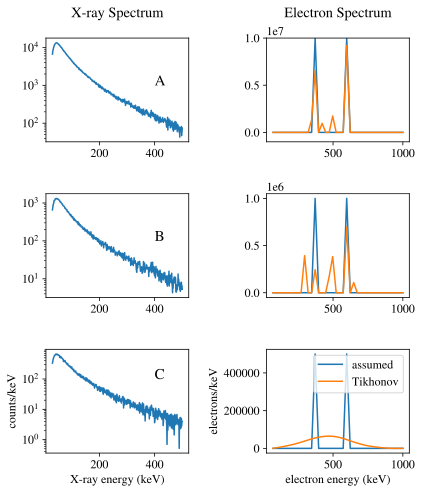

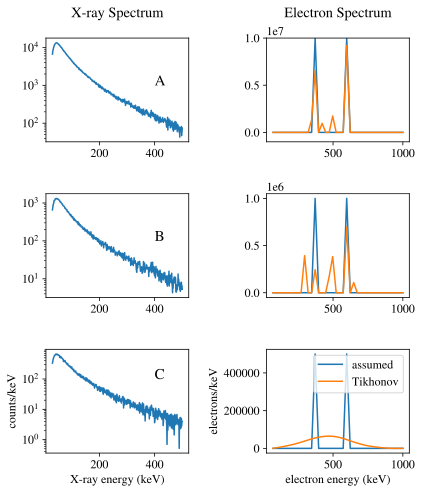

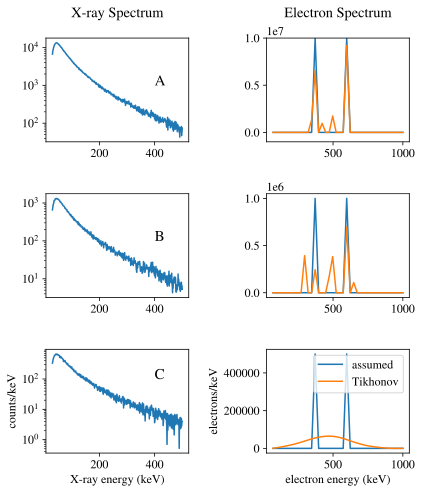

In [23]:
def cv(R, op, kappas, xs, posonly):
    err = []
    for kappa in kappas:
        e = 0
        for i in range(0, len(xs) - 1):
            RST = np.delete(R,i,0)
            xst = np.delete(xs,i,0) # delete one X-ray data point and solve the reduced problem
            sol = tk(RST, op, kappa, xst, posonly)[0]
            sol[-1] = 0
            e += (np.matmul(R,sol)[i] - xs[i])**2
        err.append(e)
    return(err)

# <codecell>

np.random.seed(123)

error = []
bias = []
k = []

# low noise 

x_low = mono(400,1e7)[0] + mono(600,1e7)[0]
e_low = mono(400,1e7)[1] + mono(600,1e7)[1]

# medium noise 

x_med = mono(400,1e6)[0] + mono(600,1e6)[0]
e_med = mono(400,1e6)[1] + mono(600,1e6)[1]

# high noise 

x_high = mono(400,5e5)[0] + mono(600,5e5)[0]
e_high = mono(400,5e5)[1] + mono(600,5e5)[1]

# solutions, no preconditioning 

err_low = cv(R, L2, np.logspace(-15,-12,20),x_low,True)
err_med = cv(R, L2, np.logspace(-10,-3,30),x_med,True)
err_high = cv(R, L2, np.logspace(-10,-3,30),x_high,True)


sol_low = tk(R,L2,np.logspace(-15,-12,20)[np.argmin(err_low)],x_low,True)[0]/2.0
sol_med = tk(R,L2,np.logspace(-10,-3,30)[np.argmin(err_med)],x_med,True)[0]/2.0
sol_high = tk(R,L2,np.logspace(-10,-3,30)[np.argmin(err_high)],x_high,True)[0]/2.0

fig = plt.figure(figsize=(6.52437527778,7.5))
gs = plt.GridSpec(nrows=3, ncols=2,hspace=.5,wspace=.545)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax5= fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

ax1.semilogy(xspace,x_low)
ax3.semilogy(xspace,x_med)
ax5.semilogy(xspace,x_high)

ax2.plot(espace,e_low)
ax2.plot(espace,sol_low)
ax2.set_ylim([-1e6,1e7])

ax4.plot(espace,e_med)
ax4.plot(espace,sol_med)

ax6.plot(espace,e_high,label='assumed')
ax6.plot(espace,sol_high,label='Tikhonov')

ax1.set_title('X-ray Spectrum\n')
ax5.set_ylabel('counts/keV')
ax2.set_title('Electron Spectrum\n')
ax6.set_ylabel('electrons/keV')

ax5.set_xlabel('X-ray energy (keV)')
ax6.set_xlabel('electron energy (keV)')

ax1.text(400, 1e3, 'A', fontsize=15)
ax3.text(400, 1e2, 'B', fontsize=15)
ax5.text(400, 1e2, 'C', fontsize=15)

ax6.legend()

plt.savefig('/Users/patrick/Documents/phd/GitHub/thesis/figures/chapter_4/two_peak_second_order_example/two_peak_second_order.pdf')
plt.show()